In [1]:
import numpy as np
import scipy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime


plt.rcParams['figure.figsize'] = (18, 6)   # or whatever you like
plt.rcParams['figure.dpi'] = 300          # optional: nicer resolution

# Set Up

In [2]:
bdf = pd.read_csv('../data/sheb_buoy.csv').set_index('day').sort_index()
bdf = bdf[['PRES', 'WTMP', 'WSPD', 'ATMP', 'WDIR']]
wdf = pd.read_csv('../data/sheb_weather_station.csv').set_index('day').sort_index()

df = pd.merge(bdf, wdf, 'outer', on='day')

df.dropna(subset=['PRES'], inplace=True)

# W/O Lake Effect

## Set up design matrix for logistic regression

In [3]:
doy = df['doy'].values
wt_minus_one = df['rain_yesterday'].values
rh = df['avg_rh'].values
pres = df['PRES'].values
wspd = df['WSPD'].values

wt = df['rain_today'].values

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()

X = np.column_stack([np.sin(2 * np.pi * doy / 365), np.cos(2 * np.pi * doy / 365), wt_minus_one, rh, pres, wspd])
X = scaler.fit_transform(X)
y = wt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=False)



## Personal implementation of logistic regression

In [ ]:
def obj(beta, X, y):
    beta = np.asarray(beta)
    z = X @ beta
    # negative log-likelihood, stable form
    # l = sum( log(1 + exp(z)) - y*z )
    return np.sum(np.logaddexp(0, z) - y * z)

def grad(beta, X, y):
    beta = np.asarray(beta)
    z = X @ beta
    p = 1 / (1 + np.exp(-z))  # sigmoid
    # gradient: X^T (p - y)
    return X.T @ (p - y)

beta0 = np.zeros(X.shape[1] + 1)
n_train, n_test = X_train.shape[0], X_test.shape[0]
X_train_p = np.column_stack([np.ones(n_train), X_train])
X_test_p = np.column_stack([np.ones(n_test), X_test])

res = minimize(
    obj,
    beta0,
    args=(X_train_p, y_train),
    jac=grad,              # <--- supply gradient
    method="L-BFGS-B",
    options={"maxiter": 1000}
)

print(res.message)
print("success:", res.success)
print("beta:", res.x)


CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
success: True
beta: [-0.98910559  0.19024475 -0.39230015  0.20496354  1.3576257  -0.10582992
  0.19065102]


In [52]:
beta = res.x
z = X_test_p @ beta
pred = 1 / (1 + np.exp(-z))

la.norm(pred - y_test)

16.77145683949325

In [34]:
random_guess = np.random.rand(len(y_test))
la.norm(random_guess - y_test)

24.32389822737601

## Statsmodel logistic regression

In [42]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model = sm.Logit(y_train, X_train_sm).fit_regularized()
probs = model.predict(X_test_sm)
la.norm(probs - y_test)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5005237563925085
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31


16.771460395516613

## Sklearn logistic regression

In [40]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=True).fit(X_train, y_train)  # X before y
labels = model.predict(X_test)  # predicted labels of X_test

In [41]:
la.norm(y_test - labels)

np.float64(20.12461179749811)

## Visualization of grouping (PCA) and predictions (Statsmodel)

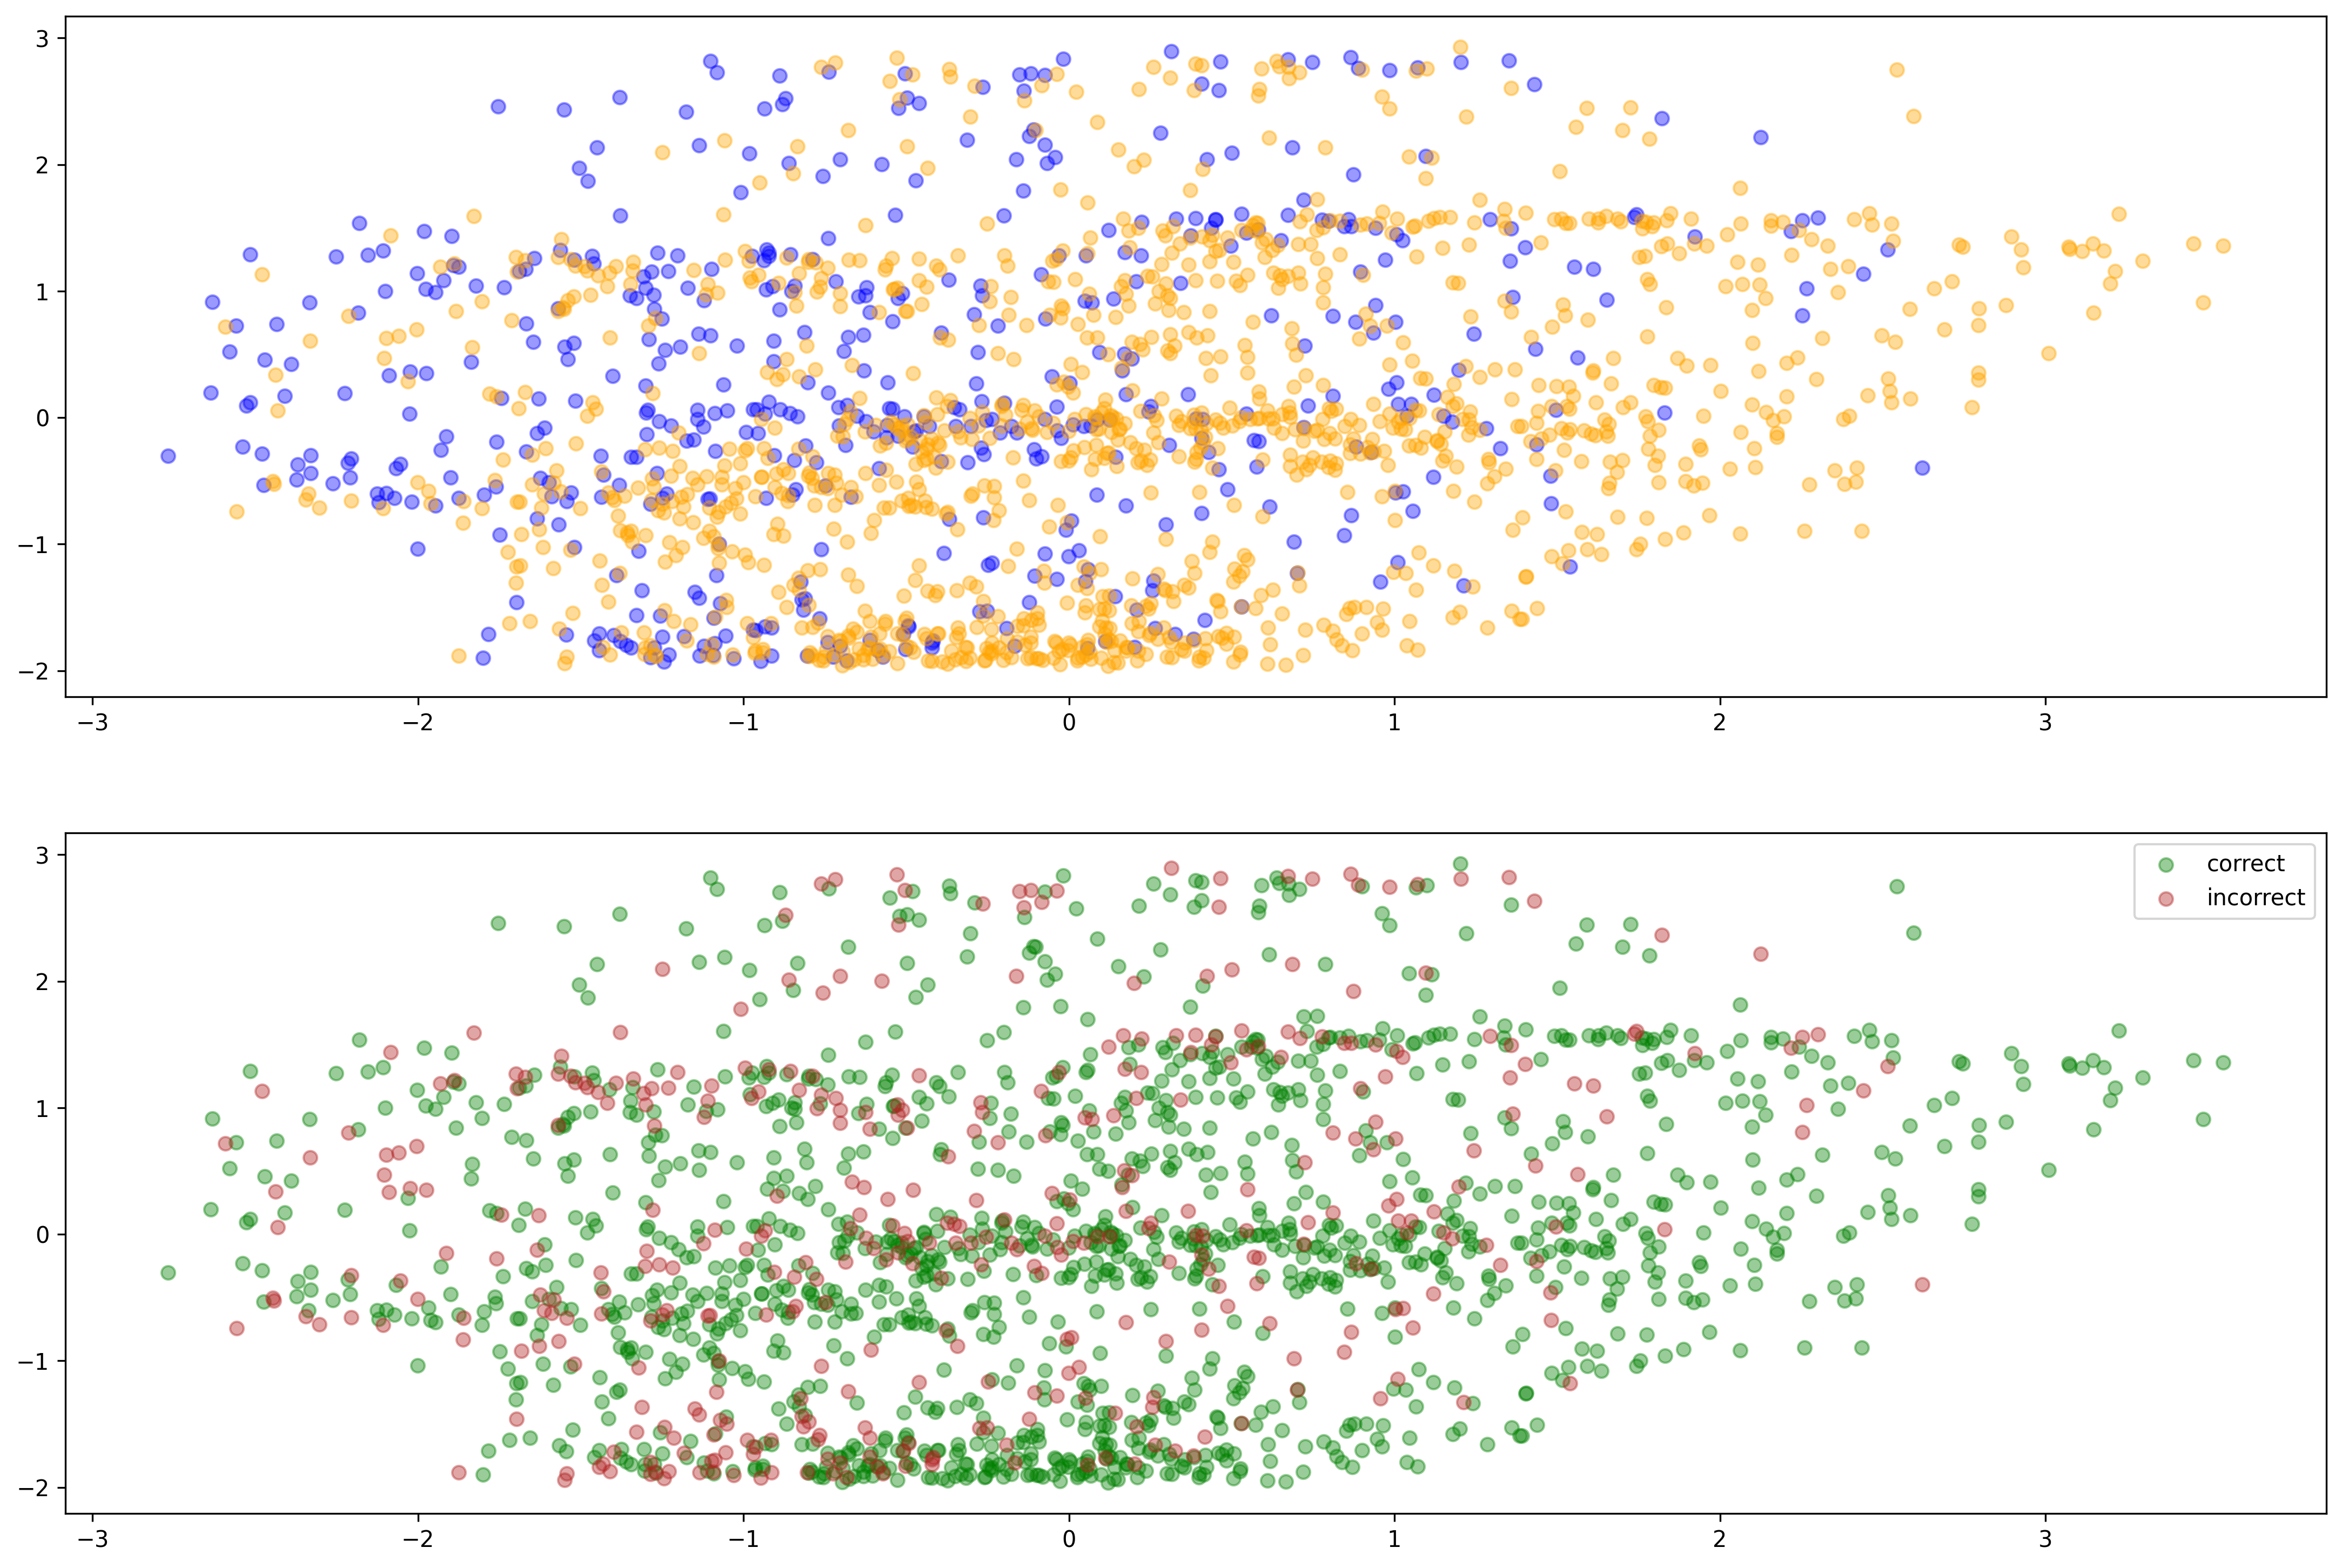

In [62]:
fig, axes = plt.subplots(2, 1, figsize=(18, 12))


mask1 = (y_test == 1)
mask2 = (np.rint(probs) == y_test)

column_means = X_test.mean(axis=0)[None, :]
X_test = X_test - column_means

U, s, Vt = la.svd(X)
coords = X_test @ Vt.T[:, :2]

ax = axes[0]
ax.scatter(coords[mask1][:, 0], coords[mask1][:, 1], alpha = 0.4, color='b', label='rain')
ax.scatter(coords[~mask1][:, 0], coords[~mask1][:, 1], alpha = 0.4, color='orange', label='shine')

ax = axes[1]
ax.scatter(coords[mask2][:, 0], coords[mask2][:, 1], alpha = 0.4, color='green', label='correct')
ax.scatter(coords[~mask2][:, 0], coords[~mask2][:, 1], alpha = 0.4, color='firebrick', label='incorrect')

plt.legend()
plt.show()


